# Workshop 1: Dimensionality Reduction

#### Descripition
This workshop aims to present how to use four algorithms for dimensionality reduction:
1. Singular-Value Decomposition (SVD)
2. Principal Component Analysis (PCA)
3. T-distributed Stochastic Neighbor Embedding (t-sne)
4. ISOMAP

**Curse**: INF8111 - Fouille de données (Prof. Daniel Aloise, Summer 2019)

**Author**: Rodrigo Randel


## Loading MNIST dataset

In [62]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
x_mnist = mnist.data.astype('float64')
y_mnist = mnist.target.astype('int32')
print('Number of samples: %d; Dimension: %d' % (x_mnist.shape[0], x_mnist.shape[1]))

Number of samples: 70000; Dimension: 784


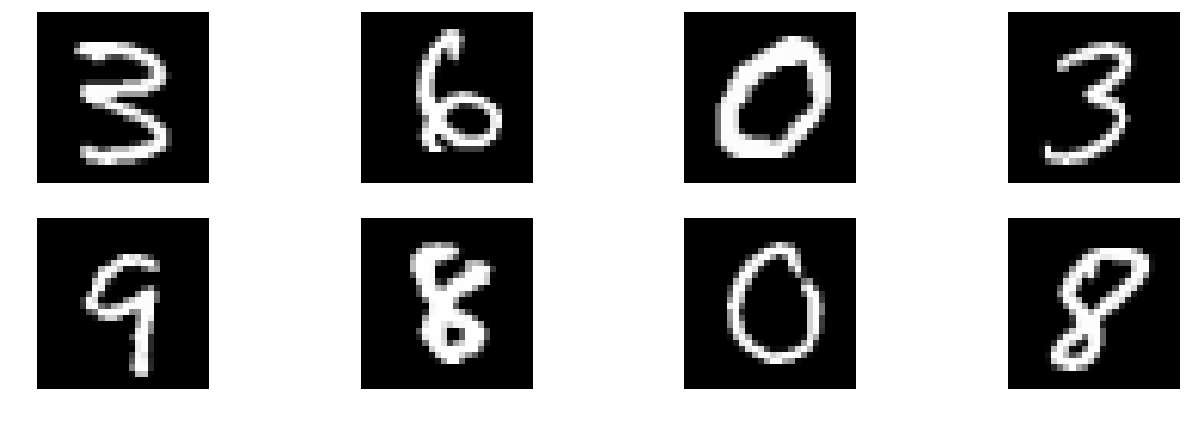

In [63]:
# plot a few samples
nrows = 2
ncols = 4
plot_slice = np.random.choice(len(x_mnist), nrows*ncols, replace=False)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,5), dpi=100)
for i in range(nrows):
    for j in range(ncols):
        axes[i, j].imshow(x_mnist[plot_slice[i*ncols+j]].reshape(28, 28), cmap='gray')
        axes[i, j].axis('off') 
plt.show()

## 1. Singular-Value Decomposition (SVD)
$$A = US V^T $$
If k is the new dimension:

$ A \rightarrow m \times n $

$U \rightarrow m \times k $
    
$S \rightarrow k \times n $
    
$V^T \rightarrow n \times k $

### 1.2 SVD using _sklearn_

In [65]:
from sklearn.decomposition import TruncatedSVD

# Define & Run SVD
svd = TruncatedSVD(n_components=200)
x_svd = svd.fit_transform(x_mnist) # map the data to the new reduced space

print('New dimension = ', x_svd.shape[1])
print('Reduction rate = %.2f%% ' % (100 - 100.0*x_svd.shape[1]/x_mnist.shape[1]))
print('Total Variance Explained = %.2f%%' % (100*np.sum(svd.explained_variance_ratio_)))

New dimension =  200
Reduction rate = 74.49% 
Total Variance Explained = 96.63%


In [66]:
# print('Singular Values:\n\t', svd.singular_values_)
# print('Explained Variance Ratio:\n\t', svd.explained_variance_ratio_)

#### Effects of SVD

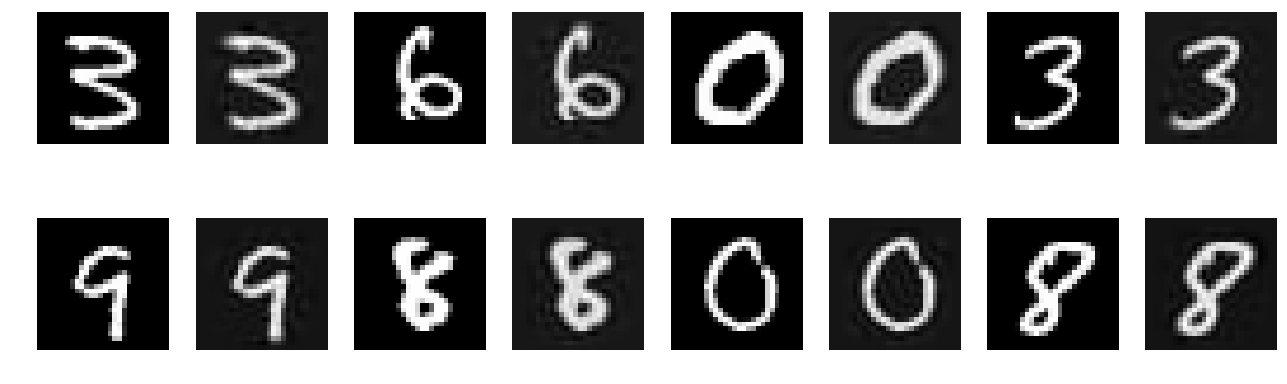

In [67]:
x_svd_inv = svd.inverse_transform(x_svd) 

fig, axes = plt.subplots(nrows=nrows, ncols=2*ncols, figsize=(16,5), dpi=100)
for i in range(nrows):
    for j in range(0,2*ncols,2):
        axes[i, j].imshow(x_mnist[plot_slice[int(i*ncols+j-j/2)]].reshape(28,28), cmap='gray')
        axes[i, j+1].imshow(x_svd_inv[plot_slice[int(i*ncols+j-j/2)]].reshape(28,28), cmap='gray')
        axes[i, j].axis('off')
        axes[i, j+1].axis('off')
plt.show()

### 1.1 SVD using _scipy_

In [68]:
from scipy.sparse.linalg import svds
# apply the decomposition
u,s,vh = svds(A = x_mnist, # mxn data 
           k=200, # new dimension: number of singular values and vectors to compute [1 <= k < min(A.shape)[.  
           return_singular_vectors=True) # Whether or not to compute u and vh. 

In [69]:
print('U shape: ', u.shape)
print('S shape: ', s.shape)
print('V shape: ', vh.shape)

U shape:  (70000, 200)
S shape:  (200,)
V shape:  (200, 784)


# 2. Principal Component Analysis (PCA)

In [70]:
# Nomalize the data
from sklearn.preprocessing import StandardScaler
x_std = StandardScaler().fit_transform(x_mnist)

In [71]:
from sklearn.decomposition import PCA

# Define & Run PCA
pca = PCA(n_components=20) # int (number of components), float (amount of variance that needs to be explained)
x_pca = pca.fit_transform(x_std)

print('New dimension = ', pca.n_components_)
print('Reduction rate = %.2f%% ' % (100 - 100.0*pca.n_components_/x_mnist.shape[1]))
print('Total Variance Explained = %.2f%%' % (100*np.sum(pca.explained_variance_ratio_)))

New dimension =  20
Reduction rate = 97.45% 
Total Variance Explained = 37.98%


In [72]:
# print('Explained Variance Ratio:\t', pca.explained_variance_ratio_)
# print('Number of components:\t', pca.n_components_)

#### Defining a _good_ number of components

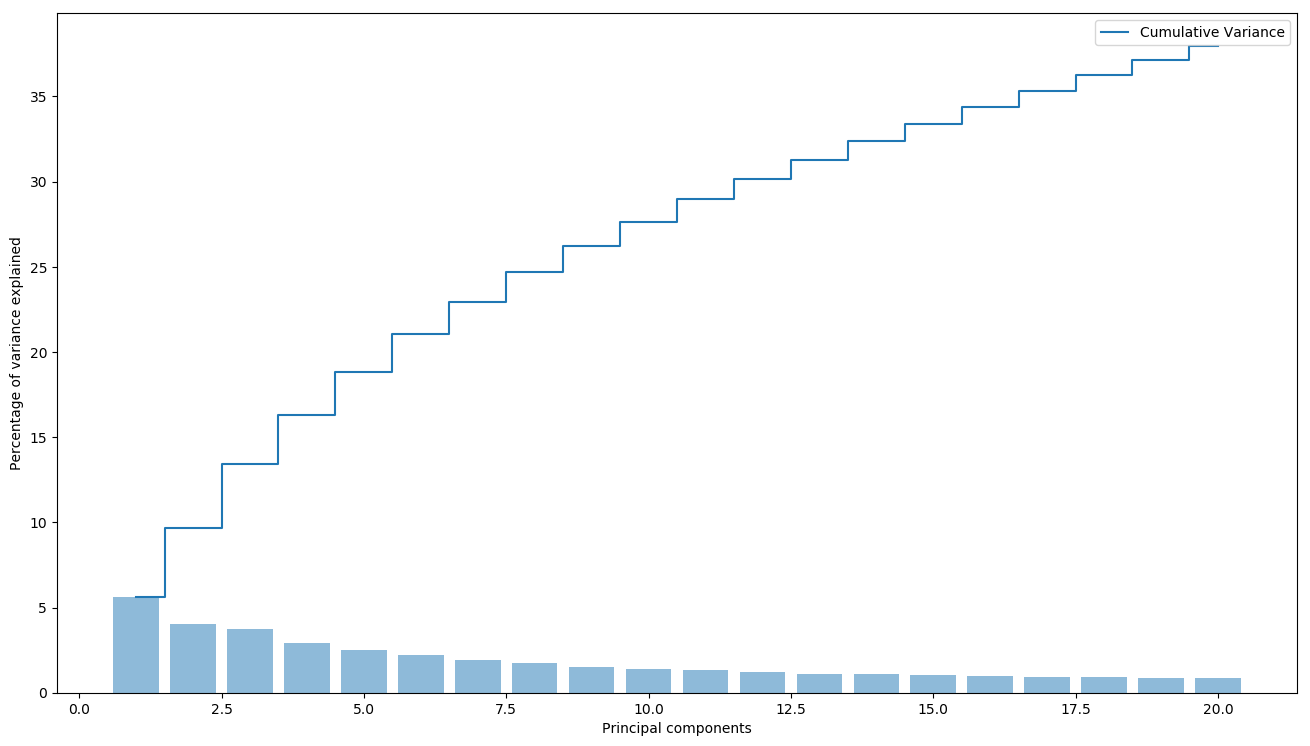

In [73]:
plt.figure(figsize=(16,9), dpi=100)
plt.bar(range(1, pca.n_components_+1), 100*pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, pca.n_components_+1), 100*np.cumsum(pca.explained_variance_ratio_), where='mid', label="Cumulative Variance")
plt.ylabel('Percentage of variance explained')
plt.xlabel('Principal components')
plt.legend()
plt.show()

#### Effects of PCA

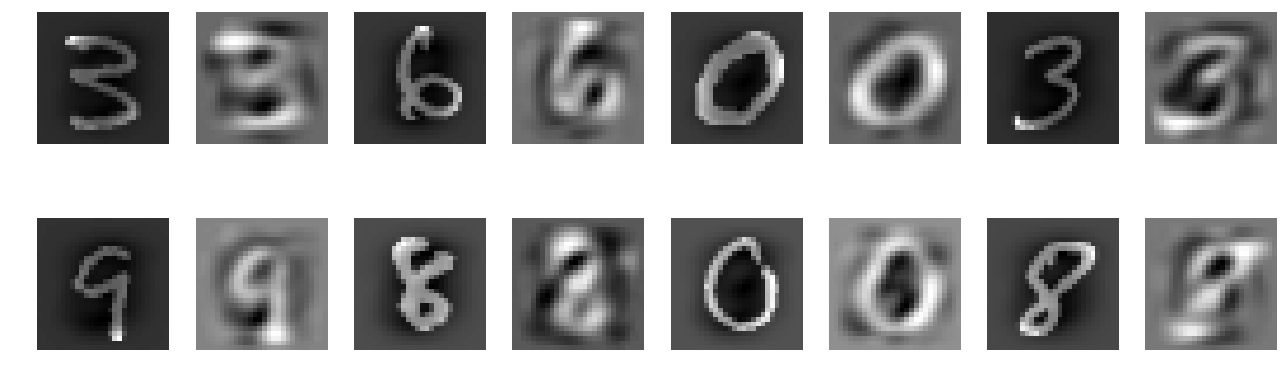

In [74]:
x_pca_inv = pca.inverse_transform(x_pca)

fig, axes = plt.subplots(nrows=nrows, ncols=2*ncols, figsize=(16,5), dpi=100)
for i in range(nrows):
    for j in range(0,2*ncols,2):
        axes[i, j].imshow(x_std[plot_slice[int(i*ncols+j-j/2)]].reshape(28,28), cmap='gray')
        axes[i, j+1].imshow(x_pca_inv[plot_slice[int(i*ncols+j-j/2)]].reshape(28,28), cmap='gray')
        axes[i, j].axis('off')
        axes[i, j+1].axis('off')
plt.show()

# T-SNE - t-distributed Stochastic Neighbor Embedding

#### Motivation

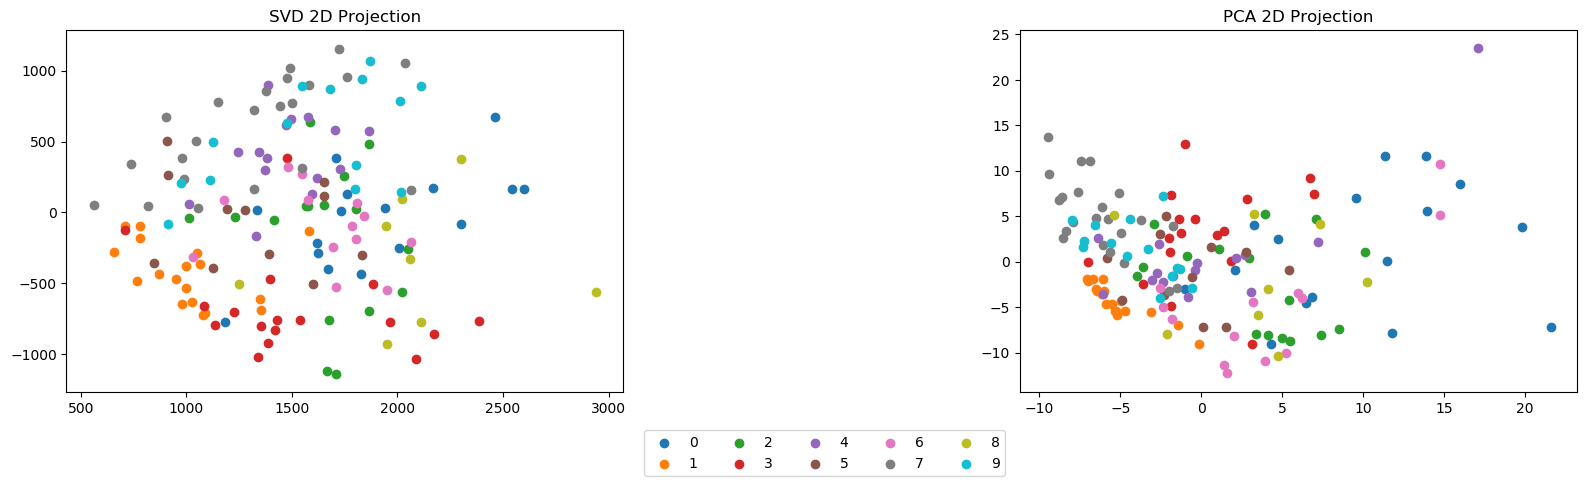

In [85]:
# Selecting 500 examples
selected = np.random.choice(len(x_mnist), 150, replace=False) 

# Run SVD for a 2D-projection
svd = TruncatedSVD(n_components=2)
x_svd = svd.fit_transform(x_mnist[selected])

# Run PCA for a 2D-projection
pca = PCA(n_components=2, svd_solver='full')
x_pca = pca.fit_transform(x_std[selected])


# Plot the projections 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5), dpi=100)
labels = set(y_mnist[selected].tolist())
for l in labels:
    axes[0].scatter(x_svd[y_mnist[selected] == l, 0], x_svd[y_mnist[selected] == l, 1], label=str(l))
    axes[1].scatter(x_pca[y_mnist[selected] == l, 0], x_pca[y_mnist[selected] == l, 1], label=str(l))
axes[0].set_title('SVD 2D Projection')
axes[1].set_title('PCA 2D Projection')    
plt.legend(loc='lower center', bbox_to_anchor=(-0.35, -0.25), ncol=5)
fig.tight_layout() 
plt.show()

#### t-sne

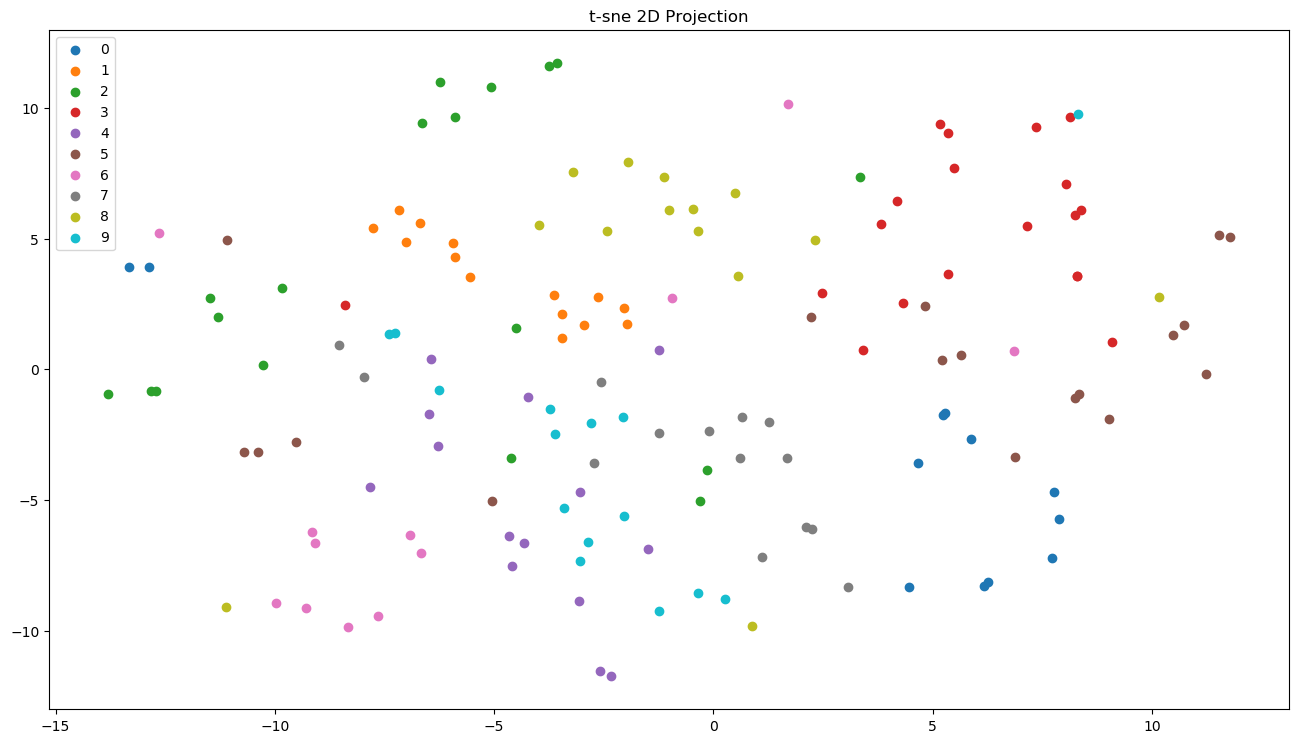

In [76]:
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances
mnist_squared = euclidean_distances(x_mnist[selected], squared=True)

tsne = TSNE(n_components=2,
            perplexity=30, # related to the number of nearest neighbors
            early_exaggeration=5, #Controls how tight natural clusters in the original space are in the embedded space
            learning_rate=200,
            n_iter=3000,
            n_iter_without_progress=300,
            random_state=10,
               metric='precomputed')
x_tsne = tsne.fit_transform(mnist_squared)

plt.figure(figsize=(16,9), dpi=100)
labels = set(y_mnist[selected].tolist())
for l in labels:
    plt.scatter(x_tsne[y_mnist[selected] == l, 0], x_tsne[y_mnist[selected] == l, 1], label=str(l))
plt.title('t-sne 2D Projection')
plt.legend(loc='best')
plt.show()

#### 3D Projection

In [77]:
tsne = TSNE(n_components=3, early_exaggeration=12,
                perplexity=100, learning_rate=200,
                n_iter=3000, n_iter_without_progress=300,
               random_state=1, init='pca')
x_tsne_3d = tsne.fit_transform(x_mnist[selected])

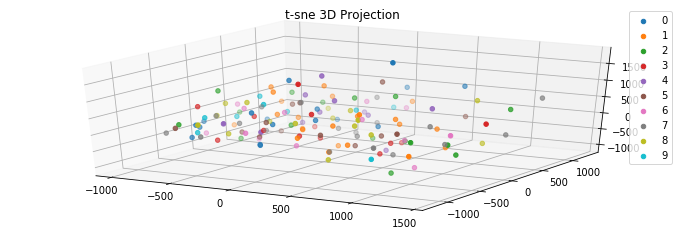

In [82]:
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111, projection='3d')
labels = set(y_mnist[selected].tolist())
for l in labels:
    ax.scatter(x_tsne_3d[y_mnist[selected] == l, 0], x_tsne_3d[y_mnist[selected] == l, 1],
                x_tsne_3d[y_mnist[selected] == l, 2], label=str(l))
    
plt.title('t-sne 3D Projection')
plt.legend(loc='best')
plt.show()

In [83]:
# back to normal plot
# %matplotlib inline 

# ISOMAP

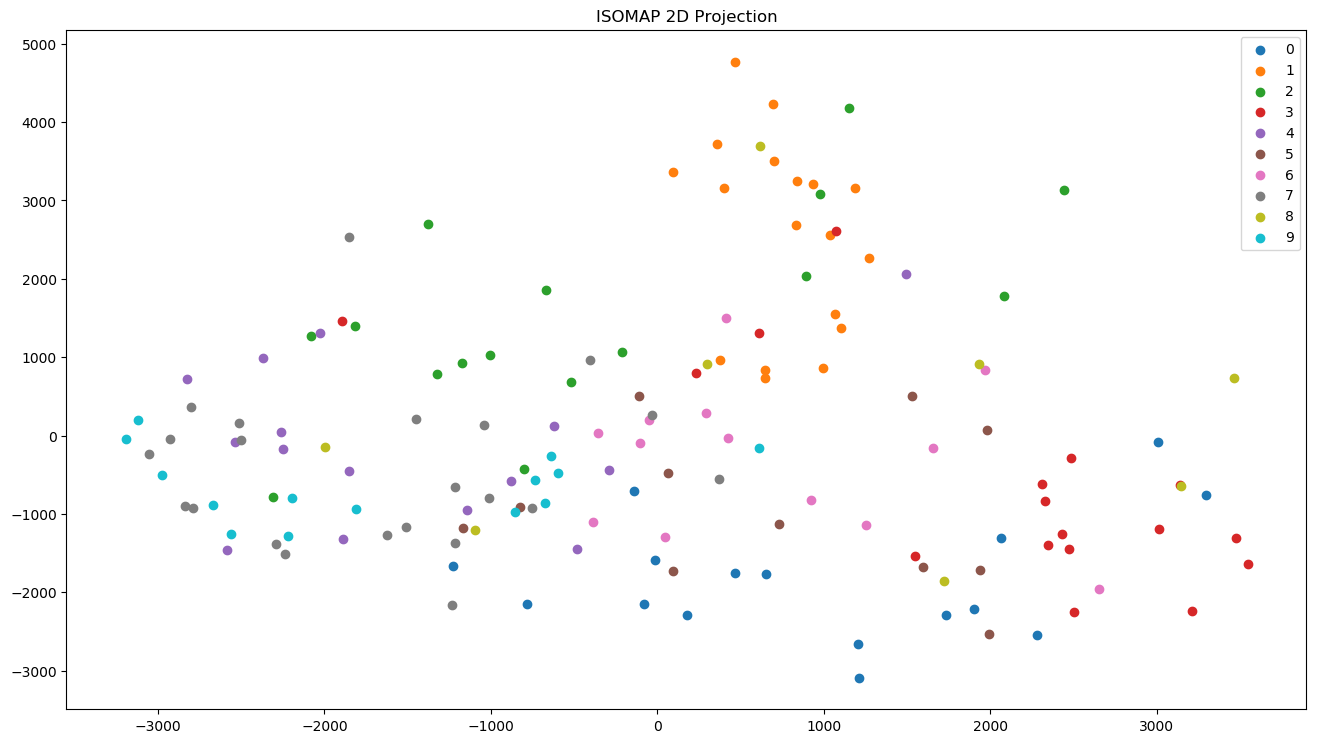

In [86]:
from sklearn.manifold import Isomap
iso = Isomap(n_neighbors=10, # number of neighbors to consider for each point.
       n_components=2, # number of coordinates for the manifold
       neighbors_algorithm='kd_tree', # algorithm to use for nearest neighbors search
       n_jobs=4)

x_iso = iso.fit_transform(x_mnist[selected])

fig = plt.figure(figsize=(16,9), dpi=100)
for l in labels:
    plt.scatter(x_iso[y_mnist[selected] == l, 0], x_iso[y_mnist[selected] == l, 1], label=str(l))
    
plt.title('ISOMAP 2D Projection')
plt.legend(loc='best')
plt.show()